<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/Example_4_2_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visulisation Example

This Tensorflow 2.x implementation is based on the paper by [Manhendran (2015)](https://arxiv.org/pdf/1512.02017.pdf)  

The layers of the pre-trained VGG-16 network are to be visualised using the activation maximisation technique presented in the paper. 

It is important to note each Feature maps of the network has a different size receptive field. We set the size of the input image to be slightly larger than the receptive field in each case. (The receptive field must be known or calculated for each feature map visualised)

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/vis_act_max.jpg?raw=true)


##Housekeeping
Load Packages & Define Helper Functions

In [1]:



from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import tensorflow as tf
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from IPython.display import clear_output
print(tf.__version__)





2.6.0


In [2]:
# Helper function to output images at end/during optimisation
def display_image(image):
   
    title = ['Generated Image']
    plt.figure(figsize=(3,3))
    plt.title(title)
    plt.imshow(np.clip(image[0,:,:,:], 0, 255).astype("uint8"),aspect="auto")
    plt.axis('off')
    plt.show()

    
def display_array(img_array,array_size):
    #unprocess model input and output
    #p_low_res = unprocess_image(low_res_input)
    #up_model_op = unprocess_image(model_op)
    n = array_size[0]
    m = array_size[1]
    plt.figure(figsize=(3*m,3*n))
    plt.title('Imaged Filters') 
    ptr = 1
    for i in range(n):      
       for j in range(m):
          ax=plt.subplot(n,m,ptr)     
          plt.imshow(np.clip((img_array[ptr,:,:,:]+127.5), 0, 255).astype("uint8"),aspect="auto")  
          ptr = ptr+1
          plt.axis('off')
    plt.show()       

In [3]:
# Imagenet Rgb
imagenet_rgb_values = [123.68, 116.779, 103.939] # Preprocessing values for imagnet (no need to adjust)

def process_image(input_img):
    op_img =[]
    r = input_img[:,:, :, 0] - imagenet_rgb_values[0]
    g = input_img[:,:, :, 1] - imagenet_rgb_values[1]
    b = input_img[:,:, :, 2] - imagenet_rgb_values[2]
    op_img = tf.stack([b,g,r],axis = 3)
    return op_img

def img_clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)

## Define Target Layer & Hyper parameters.
Parameters have same definition as in Manhedran paper.

In [4]:

# Choose target Layer of network (becomes output of reduced model)
output_layer = ['block4_conv2'] 
rho = 76 #receptive field size for layer
n_c = 5  # centre neuron (choose 1/2 Feature map spatial dimension)
filter_list =[10,51,123,198,234,343,411,455,501] # Which Feature maps to visualise

# Random image is marginaly larger than receptive field
H=100    #Input random noise image H
W=100    #Input random noise image H
T= 4     # Jitter value

# Hyperprameters.
B =  80
V = B/6.5
alpha_val = 6
beta_val = 2
M = 5500.0       # Normalisation parater experimentally determined
Z = M*(rho**2)
C=30000          # The C parameter balances the loss (activation) against regularisation it will vary depending on the layer
jitter_on=True

# Scalar for bounded range.
norm_r_alpha = 1/(H*W*(B**alpha_val))  # Alplha regulariser
# Scale for total variation regulation.
norm_r_beta  = 1/(H*W*(V**beta_val))  # Beta regulariser

## Import Model
In the following Cell the Vgg16 keras model is loaded. A modified model "red_model" is created that has a reduced input size to match that of the random image (receptive filed target neuron).Thes layers after the Feature map of interest are omitted from the model.




In [5]:
vgg16_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(H, W, 3)))


# Function to get layer output tensors & layer shapes.
def layer_data(layer_names):
    layer_shape = []  
    model_ops = []
    for layer in layer_names:
        model_ops.append(vgg16_model.get_layer(layer).output)
        layer_shape.append(vgg16_model.get_layer(layer).output_shape)
    return model_ops,layer_shape  

# Define reduced model
model_ops,output_layer_shape = layer_data(output_layer) 
red_model = tf.keras.Model(inputs = vgg16_model.input, outputs=model_ops ) 
print(output_layer_shape)

red_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
[(None, 12, 12, 512)]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
________________________________________

## Define Loss & Regularisation functions: 

In the activiation maximisation method the goal is to find the input image $x$ that maximise the value of a particular neuron. Rather than using gradient ascent, we can use gradient descent and minimise the negative of the value of the neuron. The loss function is written as the dot product of the Feature maps $\Phi(x)$ that represent the image and an indicator variable $\Phi_0$.

 $l = \frac{\langle\Phi(x),\Phi_0\rangle}{Z}$

As can be seen in the function `main_loss` the activation maximisation loss is simply written as a reduce sum of the feature map of interest. (This will often be a single neuron, an indicator varaible is not required as we explicitly select the Feature map or neuron of interest) 

Using activation maximisation loss on it's own will often not produce visually appealing images, so two regularisation functions are included to ensure the trained input images look natural. 

The bounded variation uses a soft constraint to penalise large pixel values in the image $x$ (Note the additional hard constraint mentioned in the paper is not implemented)

${N_\alpha}(x)=\frac{1}{HWB^\alpha}\sum_{v=1}^H\sum_{u=1}^W(\sum_{k=1}^Dx(v,u,k)^2)^\frac{\alpha}{2}$

This regualarisation equation is simply implemented as the function `bounded_rng_reg` where the sum of the square of the pixel of the input image are obtained and additionally raised to the power of $\frac{\alpha}{2}$

The second regularisation term is Total variation, as discussed in the paper this regulariser helps to promote consistent patches and avoid spikes in the image. (More detail on the [Total Variation](https://hal.archives-ouvertes.fr/hal-01309685v3/document) can be found here)

${R_{TV^\beta}}(x)=\frac{1}{HWB^\beta}\sum_{uvk}\Bigl((x(v,u+1,k)-x(v,u,k))^2+(x(v+1,u,k)-x(v,u,k))^2\Bigr)^\frac{\beta}{2}$

This regularisation term is implemented in the function `TV_loss`

A third type of regularisation is Jitter, this promotes sharper images. This is not implemented as part of the loss function but instead a random crop of the input image is taken each time the image is applied to the network during training (See `train_step`) function.


In [6]:
# Loss function due to activation maximisation.
def main_loss(output_features):
    #loss = tf.keras.backend.mean(model_output[:, :, :, filter_index])
    loss = -(1/Z)*tf.math.reduce_sum(output_features[:, n_c, n_c, filter_index])
    return C*loss
    
    
# Add bouded range regulariser.
def bounded_rng_reg(img):
    #square all values
    x = tf.math.square(img)
    #sum over channels
    x = tf.keras.backend.sum(x,axis=3)
    #raise to a power
    x = tf.keras.backend.pow(x,alpha_val/2)
    #sum over remaining channels
    x=tf.math.reduce_sum(x)
    #apply scalar function.
    x = norm_r_alpha*x
    return x
  
  
# conditional value to bound the output  
#  Return on a per element basis, so that are gradients for each image value.
def cond_value(img):
    x = tf.math.square(img)
    x = tf.keras.backend.sum(x,axis=3)
    y = tf.keras.backend.pow(x,1/2)  
    return y
  
  
# Differences total variation loss
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  # Pad zeros along difference dimension for von neumann boundary. (dim reduced)
  pad_x = [[0,0],[0, 0], [0, 1],[0,0]]
  pad_y = [[0,0],[0, 1], [0, 0],[0,0]]      
  x_var = tf.pad(x_var, pad_x, 'CONSTANT', constant_values=0)
  y_var = tf.pad(y_var, pad_y, 'CONSTANT', constant_values=0)       
  return x_var, y_var


# Total variation loss
def TV_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  x = (x_deltas**2) + (y_deltas**2)
  x=(tf.keras.backend.pow(x,beta_val/2))
  x=tf.reduce_sum(x)
  tv_loss = norm_r_beta*x
  return tv_loss

def total_loss(output_features,img):
    l1 =  main_loss(output_features)
    # replace conditional with log barrier to make continuous for differentiation
    l1_bnd =   bounded_rng_reg(img)
    tv_loss = TV_loss(img)
    t_loss =  l1+l1_bnd+tv_loss
    return l1,l1_bnd,t_loss,tv_loss


## Training step

The paper defines a stocasitic gradient descent algorithm, we can use the built in SGD optimiser to produce the image for the required filters.

In order to use the activation maximisation technique we cannot use the standard Keras model.fit methodology. Instead we directly apply the Tensorflow automatic differentiation using [gradient tape](https://www.tensorflow.org/guide/autodiff)

The keras implementation adam optimiser produces good results and is used instead of the SGD algorithm detailed in the paper.

In [7]:

# optimiser for gradients
adam_optimiser = tf.keras.optimizers.Adam(0.1, beta_1=0.09, beta_2=0.99, epsilon=1e-7)

# Traing step function
def train_step(rnd_img_data):
  with tf.GradientTape() as gen_tape:
    
    gen_tape.watch(rnd_img_data)  
    if jitter_on == True:   
       inp_img = tf.image.random_crop(rnd_img_data,(1,H,W,3))
    else:
        inp_img = rnd_img_data
    op_features=red_model(process_image(inp_img+127.0))
    nx = np.max(cond_value(rnd_img_data))
    l1,l1_bnd,t_loss,tv_loss = total_loss(op_features,rnd_img_data)
 
  img_grads = gen_tape.gradient(t_loss,rnd_img_data)
  adam_optimiser.apply_gradients([(img_grads,rnd_img_data)])
  return l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss


## Run Training
Running the training step. The number of iterations of training can be set. An image corresponding to each layer of the feature map is plotted as it is completed. (The exact set of feature maps is determined by the variable `filter_list` defined earlier.) (The max number that can be plotted depends on the depth of the feature map, note some deep feature maps have a depth of 512!!!)

NB: On occasion no image is produced, this is due to the stochastic nature of the process.



Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


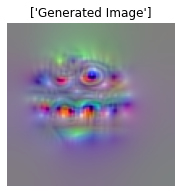

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


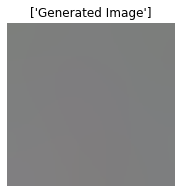

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


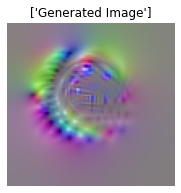

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


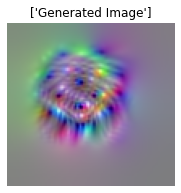

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


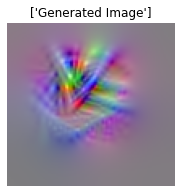

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


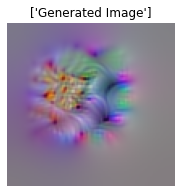

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


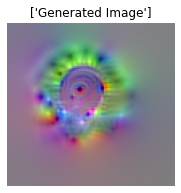

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


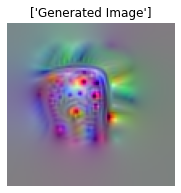

Iteration Number = 0
Iteration Number = 100
Iteration Number = 200
Iteration Number = 300
Iteration Number = 400
Iteration Number = 500
Iteration Number = 600
Iteration Number = 700
Iteration Number = 800
Iteration Number = 900
Iteration Number = 1000
Iteration Number = 1100
Iteration Number = 1200
Iteration Number = 1300
Iteration Number = 1400
Iteration Number = 1500
Iteration Number = 1600
Iteration Number = 1700
Iteration Number = 1800
Iteration Number = 1900


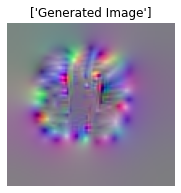

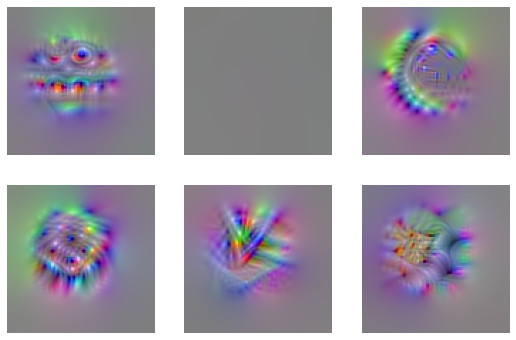

In [8]:
iterations = 2000

layer_images =  tf.Variable(np.zeros([1,H+T,W+T,3]))
layer_images = tf.cast(layer_images, dtype='float32')

# Code to produce multiple filter images in each layer.
for filter_index in filter_list:
    # reset random vector
    rnd_img_data = tf.Variable( tf.random.normal([1, H+T,W+T,3],mean=0,stddev=30.0,name="input_img_data"))
    rnd_img_data = tf.cast(rnd_img_data, dtype='float32')
    
    for iterations in range(iterations):
        l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss = train_step(rnd_img_data)
        if iterations % 100 == 0:
          print('Iteration Number =',iterations)
    layer_images = tf.concat([layer_images, rnd_img_data],0) 
    display_image(rnd_img_data+127.0)
# reshape into grid and display (Set depending on no. feature maps visualised).    
display_array(layer_images,(2,3))




# Run training step (Debug mode)

In the cell below the training step is run for a single feature map. Images are output more frequently and values of the loss and regulariser are output to verify that the training is processing correctly. 



In [ ]:
# Test one image

iterations = 2000
filter_index =245


# initialise noise vector
rnd_img_data = tf.Variable( tf.random.normal([1, H+T,W+T,3],mean=0,stddev=30.0,name="input_img_data"))
rnd_img_data = tf.cast(rnd_img_data, dtype='float32')

for iterations in range(iterations):
    #pert_noise = tf.random.normal([1, H+T,W+T,3],mean=0.0,stddev=1)
    #latent_vector=rnd_img_data+pert_noise
    l1,l1_bnd,t_loss,rnd_img_data,nx,tv_loss = train_step(rnd_img_data)
    if iterations % 100 == 0:
       print('Iteration Number =',iterations)
       print('Total loss =',t_loss)
       print('Feature Maximisation =',l1)
       print('Bounded regularisation =',l1_bnd)
       print('Total Variation =',tv_loss)
       print(nx)
       #print('Total Variation Loss=',tv_loss)
       display_image(rnd_img_data+127.0)

## Finding M paramter (This is not requred unless setting up for different layers, networks etc)
This paramter is determined by inputing an image (loaded via google drive in this case) to the network and finding the receptive value of the target neuron.

In [10]:
"""
from google.colab import drive
drive.mount('/content/gdrive')
"""



"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [11]:
"""
source_img_path = '/content/gdrive/My Drive/style_xfer_images/Red_Fox.jpg'
#source_img_path = '/content/gdrive/My Drive/Photos/S1630013.JPG'


img1_file = tf.io.read_file(source_img_path)
img1 = tf.image.decode_jpeg(img1_file,channels=3)
img1.set_shape([None, None, 3])
img1_resized = tf.image.resize(img1, [H,W])
img1_resized = tf.expand_dims(img1_resized, axis=0)

output_vals=red_model(process_image(img1_resized))
print(np.max(output_vals))

M = np.max(output_vals) # Maximum value receptive component (neuron) from IMAGENET data
Z = M*(rho**2)
print(np.shape(output_vals))
"""

"\nsource_img_path = '/content/gdrive/My Drive/style_xfer_images/Red_Fox.jpg'\n#source_img_path = '/content/gdrive/My Drive/Photos/S1630013.JPG'\n\n\nimg1_file = tf.io.read_file(source_img_path)\nimg1 = tf.image.decode_jpeg(img1_file,channels=3)\nimg1.set_shape([None, None, 3])\nimg1_resized = tf.image.resize(img1, [H,W])\nimg1_resized = tf.expand_dims(img1_resized, axis=0)\n\noutput_vals=red_model(process_image(img1_resized))\nprint(np.max(output_vals))\n\nM = np.max(output_vals) # Maximum value receptive component (neuron) from IMAGENET data\nZ = M*(rho**2)\nprint(np.shape(output_vals))\n"